# Neural Network from scratch
The goal of this notebook is to implement a basic neural network using only `numpy`, and explore how the depth (no. of layers) and breadth (no. of units in a layer) of a neural network enables it to better classify to non-linear datasets.

The notebook is divided into two parts:
- Implementation: code for the neural network
- Results: analysis of neural network configuration for fitting non-linear datasets

# Neural Network Implementation
For the implementation of the neural network, we will implement the following features only since we are only interested in classification capabilities:

- Activation functions: ReLU, Linear, Sigmoid
- Loss function: Hinge

The neural network will also be lacking the following features:
- Regularization
- Regression

The limitations of the following implementation are:
- only able to use labels `[-1, 1]` because only hinge loss is implemented. 
- only able to use linear activation function for output layer 

## Implementation of Activation functions

In [17]:
import numpy as np
import logging

logging.basicConfig(level=logging.DEBUG)

class Activation:
    def __init__(self, f, df):
        """
        Initialize Activation object. Represents the activation fn for a layer
        
        :params f: function that takes column vector and returns column vector
        :params df: corresponding derivative of f
        """
        self.f = f
        self.df = df
    
    def call(self, x):
        return self.f(x)
    
    def call_df(self ,x):
        return self.df(x)

In [18]:
def relu(x):
    """
    ReLU activation function

    :params x: np vector
    :returns: np vector
    """
    x[x < 0] = 0

    return x
def d_relu(x):
    """
    ReLU derivative
    
    :params x: np vector of shape mx1
    :returns: np matrix of shape mxm
    """
    x = relu(x)
    x[x > 0] = 1
    return np.diag(x.T[0])

def sigmoid(x):
    """
    Sigmoid activation function

    
    :params x: np vector
    :returns: np vector
    """    
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    """
    Sigmoid derivative
    
    :params x: np vector of shape mx1
    :returns: np matrix of shape mxm
    """
    exp = np.exp(-x)
    return np.diag((exp/(1+exp)**2).T[0])

def linear(x):
    """
    Linear activation function
    
    :params x: np vector of shape mx1
    :returns: np vector of shape mx1
    """
    return x

def d_linear(x):
    """
    Linear derivative
    
    :params x: np vector of shape mx1
    :returns: np matrix of shape mxm
    """
    m, n = x.shape
    return np.identity(m)

activation_functions = {
    "relu": Activation(relu, d_relu),
    "sigmoid": Activation(sigmoid, d_sigmoid),
    "linear": Activation(linear, d_linear)
}

## Implementation of a loss function

In [19]:
class Loss:
    def __init__(self, f, df):
        """
        Initialize Loss object. Represents the loss function for a model
        
        :params f: fn taking ans cv and prediction cv and return loss (1, 1)
        :params df: corresponding derivative of f w.r.t prediction
        """
        self.f = f
        self.df = df
    
    def call(self, g, a):
        """
        Calculate loss of dataset given predictions (guesses) and labels (answers)
        
        :params g: guesses of model. (n, 1)
        :params a: answers to guesses. (n, 1)
        """
        return self.f(g, a)
    
    def call_df(self, g, a):
        return self.df(g, a)
    

In [20]:
def hinge_loss(g, a):
    """
    Hinge loss
    
    :params g: column vector of guesses for all data pt
    :params a: column vector of answers
    """
    x = 1 - np.multiply(g, a)
    x[x < 0] = 0
    
    return np.sum(x)

def d_hinge_loss(g, a):
    """
    Hinge loss derivative for single data point
    
    :params g: model guess (1x1)
    :params a: correct answer (1x1)
    """
    if a.dot(g)[0,0] > 1:
        return np.array([[0]])
    else:
        return np.array(-a)

def NLL(g, a):
    """
    Negative Log Likelihood
    
    :params g: column vector of guesses for all data pt
    :p
    """
    

loss_functions = {
    "hinge": Loss(hinge_loss, d_hinge_loss)
}

## Implementation of a neural network layer

In [66]:
class Layer:
    def __init__(self, w, g, af, output=False):
        """
        Initialize a Layer object.
        Only can perform stochastic gradient descent
        
        :params w: mxn np matrix where m is input vec length, n is no. of units
        :params g: nx1 np matrix where n is the no. of units
        :params af: activation function object
        :params output: boolean for whether layer is output layer or intermediate
        """
        m, n = w.shape
        
        self.weights = w
        self.gain = g
        self.activation_fn = af
        
        self.input_dim = (m, 1)
        self.output_dim = (n, 1)
        
        self.output_layer = output
    
    def call(self, x):
        """
        run input vector through layer

        :params x: column vector of size self.input_dim
        :returns: column vector of size ouput_dim
        """
        if x.shape != self.input_dim:
            raise Exception("Wrong input dimension")
        return self.activation_fn.call(self.weights.T.dot(x) + self.gain)
    
    def backprop_call(self, x):
        """
        run input vector through layer to produce outputs for backprop
        
        :params x: column vector of size self.input_dim
        :returns: tuple (z, a), where z is tf by units, and a is activation
        """
        if x.shape != self.input_dim:
            raise Exception("Wrong input dimension")
        z = self.weights.T.dot(x) + self.gain
        a = self.activation_fn.call(z)
        
        return(z, a)
    
    def dadz(self, z):
        """
        Get dadz for backprop. Refer to the math
        
        :params z: tf from this layer units
        :returns: nxn matrix
        """
        return self.activation_fn.call_df(z)
        
    
    def dldz(self, dldz_front, w_front, z):
        """
        get dldz for backprop. Refer to the math.
        
        :params dldz_front: column vector of dldz for layer in front (k, 1)
        :params w_front: weights of layer in front (n, k)
        :params z: output of current layer tf for the given data point (n, 1)
        :returns: column vector of dldz (n, 1)
        """
        if self.output: raise Exception("Output layer")
        return activation_fn.call_df(z).dot(w_front).dot(dldz_front)
        
    
    def dldw(self, a, dldz):
        """
        get gradient of weights for backprop. Refer to the math.
        
        :params dldz: (n, 1)
        :params a: input from layer below (m, 1)
        :returns: column vector of dldw (m, n)
        """
        return a.dot(dldz.T)
    
    
    def sgd_step(self, dldw, step_size):
        """
        update weights according to given gradient and step size
        
        :params dldw: gradient of current weights w.r.t data pt (m, n)
        :params step_size: step size to take. number
        :returns: True
        """
        self.weights = self.weights - dldw*step_size
    
    def sgd_step_gain(self, dldw0, step_size):
        """
        update weights according to given gradient and step size
        
        :params dldw0: column v gradient of current weights w.r.t data pt
        :params step_size: step size to take. number
        :returns: True
        """
        self.gain = self.gain - dldw0*step_size
        

## Neural Network Implementation

In [184]:
class NeuralNetwork:
    def __init__(self, loss, layers, input_dim, weights = None, verbose=False):
        """
        Create a neural network. 
        Note: Model does not implement bias and regularization.
        
        :params loss: string of loss fn
        :params layers: array of tuples (unit_no, activation_fn)
        :params input_dim: integer of input dimension
        :params weights: array of tuples (weight, gain)
        """
        self.loss_fn = loss_functions[loss]
        self.verbose = verbose
        
        def create_layer(input_dim, unit_no, af, weight=None, gain=None, output=False):
            #w = np.random.normal(scale=1/input_dim,size=(input_dim, unit_no))
            if isinstance(weight, np.ndarray):
                w = weight
            else:
                w = np.random.normal(scale=1/input_dim,size=(input_dim, unit_no))
                
            if isinstance(gain, np.ndarray):
                g  = gain
            else:
                g = np.random.normal(size=(unit_no, 1))
            return Layer(w, g, af, output)
        
        self.layers = []
        for idx, layer in enumerate(layers):
            unit_no, af = layer
            layer_obj = None
            if idx == 0:
                if weights[idx] != None:
                    weight, gain = weights[idx]
                    layer_obj = create_layer(\
                                        input_dim,\
                                        unit_no,\
                                        activation_functions[af],\
                                        weight,\
                                        gain
                                      )
                else:
                    layer_obj = create_layer(\
                                       input_dim,\
                                       unit_no,\
                                       activation_functions[af]
                                      )
            else:
                unit_no_before, _ = layers[idx - 1]
                if weights[idx] != None:
                    weight, gain = weights[idx]
                    layer_obj = create_layer(\
                                        input_dim,\
                                        unit_no,\
                                        activation_functions[af],\
                                        weight,\
                                        gain
                                      )
                else:
                    layer_obj = create_layer(\
                                         unit_no_before,\
                                         unit_no,\
                                         activation_functions[af]
                                         )
            if idx == len(layers) - 1:
                layer_obj.output_layer = True
                                         
            self.layers.append(layer_obj)
            
    def run(self, X):
        """
        Run data through the neural network
        
        :params X: mxn matrix where m is data dim and n is no of data pt
        """
        m, n = X.shape
        Y = []
        for x in X.T:
            x = np.array([x]).T
            for layer in self.layers:
                x = layer.call(x)
            Y.append(x[0])
        return np.array(Y)
        
    def train(self, data, labels, T=1000):
        """
        Train model using stochastic gradient descent
        
        :params data: mxn matrix where m is data dim and n is no. of data pt
        :params labels: 1xn matrix for the labels
        """
        m, n = data.shape
        d_loss = self.loss_fn.call_df
        
        step_fn = lambda t: 1/(t+1)
        for t in range(T):
            i = np.random.randint(n)
            data_pt = np.array([data.T[i]]).T
            label = np.array([[labels[0,i]]])
            layer_outputs = [(None, data_pt)]
    
            x = data_pt
            
            #Forward pass to compute layer outputs
            for layer in self.layers:
                z, a = layer.backprop_call(x)
                x = a
                layer_outputs.append((z, a))
            
            #Backpropogation
            dlda = None
            x = data_pt
            for idx in range(len(self.layers)-1, -1, -1):
                z, a = layer_outputs[idx+1]
                layer = self.layers[idx]
                _, prev_a = layer_outputs[idx]
                    
                if layer.output_layer:
                    dlda = d_loss(a, label)
                
                dadz = layer.dadz(z)
                dldz = dlda.dot(dadz)
                dldw = prev_a.dot(dldz)
                dldw0 = dldz.T
                
                if self.verbose:
                    print("prev a:", prev_a)
                    print("\nz:", z, "\na:", a)
                    print("\n\ndata:", x, "label:",label)
                    print("dlda: ", dlda)
                    print("dldz:", dldz, "dldw:", dldw)
                    print("weights:", layer.weights)
                    
                
                dlda = dldz.dot(layer.weights.T)
                layer.sgd_step(dldw, step_fn(t))
                layer.sgd_step_gain(dldw0, step_fn(t))
        
        

# Results
This section will explore how the depth and breadth of a neural network enables it to better classify non-linear datasets

## Generate Classifiable data
We need to be able to generate data that can be classifiable. The following code block will contain functions for generating random data, increasing the dimensionality of the data using polynomials, and classifying the data.
### Dimensionality Increase
The dimensionality increase function uses the following method:

Given an input vector $[x_1, \dots, x_n]$, we will increase the dimensionality via:
$$ [x_1, \dots, x_n, x_1^2,\dots, x_n^2,\dots,x_1^d, \dots, x_n^d]$$
### Classifier
The classifier uses a hyperplane to classify input data into either `1, -1`

Given an input column vector $v = [x_1,\dots,x_n]^T$ and the following coefficients row vector $x = [c_1,\dots,c_n]$, the classifier uses the following equation:

$$f(v) = x\cdot v = c_1x_1 + c_2x_2 + \dots + c_nx_2 $$ such that

$$\text{label}(v) = \begin{cases} 1 & f(v) > 0 \\ -1 & f(v) \leq 0\end{cases}$$

In [221]:
def create_random_linear_classifier(dim):
    w = np.random.uniform(-3, 3, size=(dim, 1))
    def classifier(x):
        y = w.T.dot(x)
        y[y > 0] = 1
        y[y <= 0] = -1
        return y
    return classifier

def create_polynomial_classifier(dim, deg):
    linear_classifier = create_random_linear_classifier(dim*deg)
    def classifier(x):
        poly_data = create_polynomial_data(x, deg)
        return linear_classifier(poly_data)
    return classifier

def create_polynomial_data(x, deg):
    """
    Increase the dimensionality of dataset
    [x_1, ..., x_n, x_1^2, ..., x_n^2, ..., x_1^d, ..., x_n^d]
    
    :params x: data to be processed in shape (d, n)
    :params deg: polynomial degree of classifier
    """

    d, n = x.shape
    new_x = [x]
    for _ in range(deg - 1):
        prev_x = x
        new_x.append(np.multiply(x, prev_x))
    new_x = np.array(new_x)
    new_x = new_x.reshape((deg*d, n))
    return new_x

def create_random_data(dim, n):
    return np.random.uniform(-5, 5, size=(dim, n))

## Metrics
Code block for utility functions to evaluate performance of the model

In [216]:
def accuracy(g, a):
    """
    metric for how many guesses are correct
    """
    score = 0
    n, _ = g.shape
    for i, x in enumerate(g):
        if x[0] == a[0, i]:
            score += 1
    return score/n

def classify_pred(pred):
    pred[pred > 0] = 1
    pred[pred <= 0] = -1
    return pred

def eval_model(model, data, labels):
    """
    Evaulate accuracy of a model
    """
    pred_classes = classify_pred(model.run(data))
    return accuracy(pred_classes, labels)

In [259]:
def vary_layer_performance(max_layer, unit_no, deg, data_dim, data_amt, sample_no):
    """
    Given a model with intermediate layers with const no. of units, this 
    function tests the accuracy of models with depth of 1 to max_layer 
    on random classifiable datasets of constant degree deg
    
    :params max_layer: maximum layer amt to test
    :params unit_no: no. of units for each intermediate layer
    :params deg: polynomial degree of classifier
    :params data_dim: dimension of base data
    :params data_amt: no. of data points
    :params sample_no: no. of times to train/test each nn for computing mean acc
    :returns: array of accuracy tuples (untrained, trained) for each neural network
    """
    accuracies = []
    
    for layer_amt in range(max_layer):
        layer_arr = [(unit_no, "relu") for _ in range(layer_amt)]
        layer_arr.append((1, "linear"))
        
        # initialize non random weights for model
        weights = []
        for i, layer in enumerate(layer_arr):
            if i == 0:
                weight = np.ones((data_dim, layer[0]))*1/data_dim
                gain = np.zeros((layer[0], 1))
                weights.append((weight, gain))
            else:
                prev_layer_units = layer_arr[i-1][0]
                weight = np.ones((prev_layer_units, layer[0]))
                gain = np.zeros((layer[0], 1))
                weights.append((weight, gain))
        
        untrained_acc = 0
        trained_acc = 0
        for _ in range(sample_no):
            nn = NeuralNetwork("hinge", layer_arr, data_dim, weights=weights)
            classifier = create_polynomial_classifier(data_dim, deg)
            train_data = create_random_data(data_dim, data_amt)
            train_labels = classifier(train_data)
            
            test_data = create_random_data(data_dim, data_amt)
            test_labels = classifier(test_data)
            
            untrained_acc += eval_model(nn, test_data, test_labels)
            
            nn.train(train_data, train_labels, T=data_amt*10)

            trained_acc += eval_model(nn, test_data, test_labels)

        accuracies.append((untrained_acc/sample_no, trained_acc/sample_no))
    
    return accuracies
    

In [297]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_accuracies(acc, title):
    untrained_acc, trained_acc = ([i for i, j in acc],
       [j for i, j in acc])
    X = [i + 1 for i in range(len(acc))]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(xlabel='no. of layers', ylabel='accuracy')
    ax.plot(X, untrained_acc, label="untrained")
    ax.plot(X, trained_acc, label="trained")
    ax.legend(loc="lower right")
    ax.title.set_text(title)
    ax.set_ylim([0,1])
    fig.show()
    

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


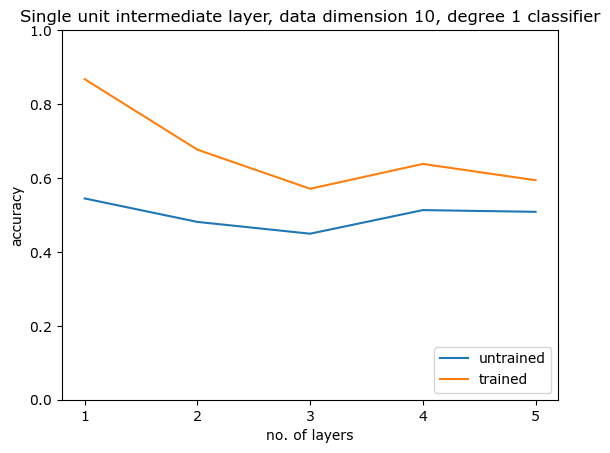

In [306]:
acc = vary_layer_performance(5, 1, 1, 10, 500, 15)
plot_accuracies(acc,"Single unit intermediate layer, data dimension 10, degree 1 classifier")

## Analysis
Here, the data is classified using a linear classifier. The best performing model has 1 layer with 1 unit - equivalent to a support vector machine. 

More complicated layers can't predict the test data properly because of estimation error and overfitting to the training set.

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


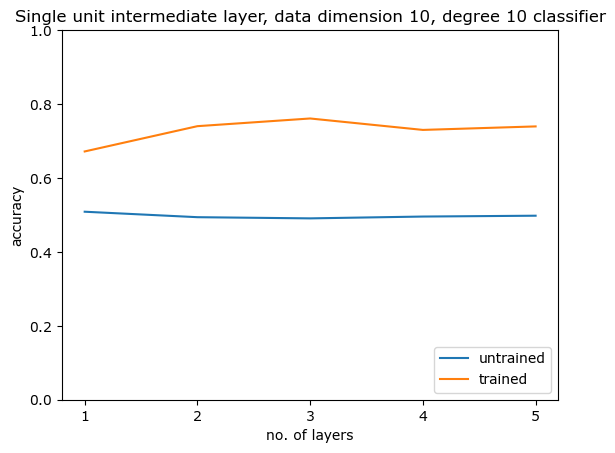

In [305]:
acc = vary_layer_performance(5, 1, 10, 10, 500, 15)
plot_accuracies(acc,"Single unit intermediate layer, data dimension 10, degree 10 classifier")

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


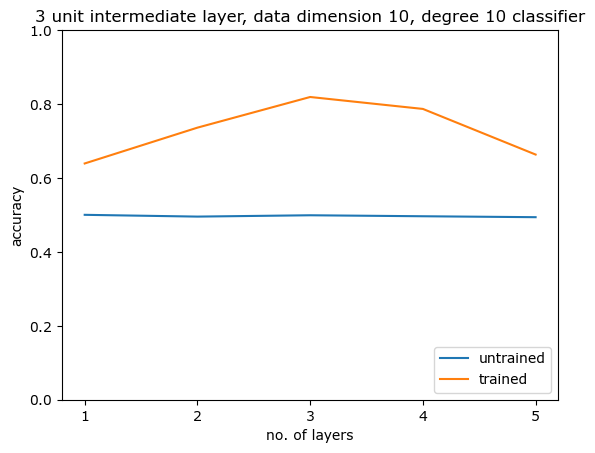

In [307]:
acc = vary_layer_performance(5, 3, 10, 10, 500, 15)
plot_accuracies(acc,"3 unit intermediate layer, data dimension 10, degree 10 classifier")

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


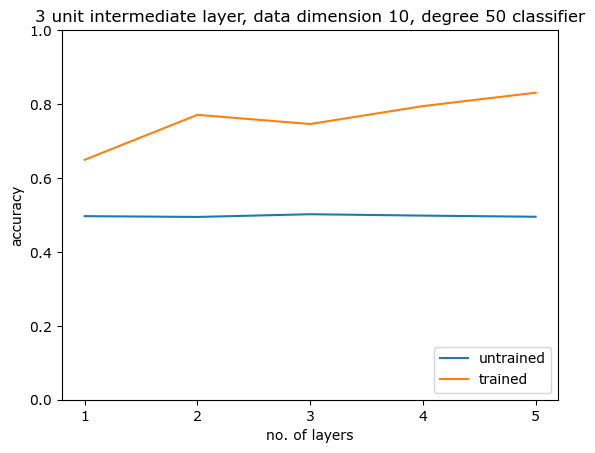

In [308]:
acc = vary_layer_performance(5, 3, 50, 10, 500, 15)
plot_accuracies(acc,"3 unit intermediate layer, data dimension 10, degree 50 classifier")

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


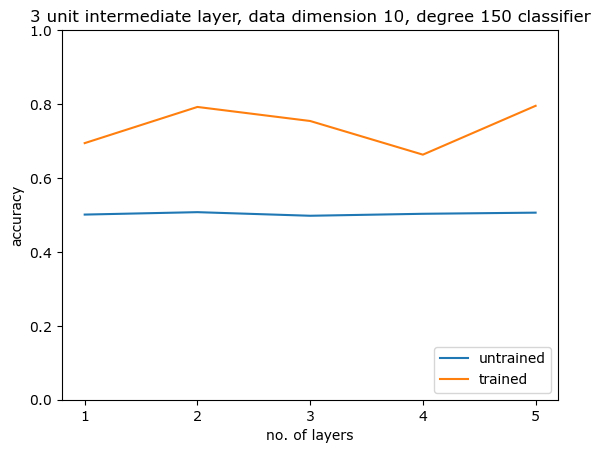

In [309]:
acc = vary_layer_performance(5, 3, 150, 10, 500, 15)
plot_accuracies(acc,"3 unit intermediate layer, data dimension 10, degree 150 classifier")

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


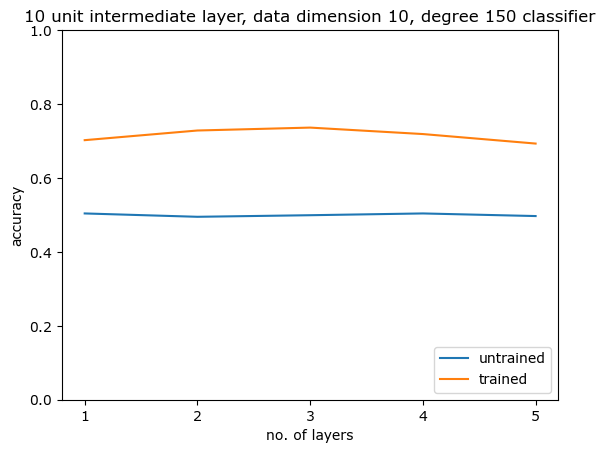

In [314]:
acc = vary_layer_performance(5, 10, 150, 10, 500, 15)
plot_accuracies(acc,"10 unit intermediate layer, data dimension 10, degree 150 classifier")

/private/var/mobile/Containers/Data/Application/538C5337-6F0E-47CA-BE68-5AD1C5BB9E01/tmp/ipykernel_301/4076225325.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


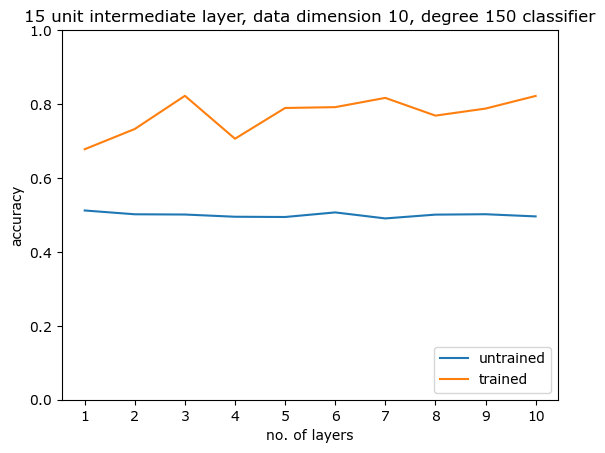

In [315]:
acc = vary_layer_performance(10, 15, 150, 10, 500, 15)
plot_accuracies(acc,"15 unit intermediate layer, data dimension 10, degree 150 classifier")

# Test code

In [72]:
data_dim = 2
data_amt = 3

data = create_random_data(data_dim, data_amt)
classifier = create_random_linear_classifier(data_dim)
labels = classifier(data)

params = {
    "loss": "hinge",
    "layers": [(3, "relu"), (2, "relu"), (1, "linear")],
    "input_dim": data_dim
}
print("data:\n",data)
print("labels:\n", labels)


data:
 [[-0.86518876 -0.19307722  0.37045556]
 [ 0.15778863  0.20740357 -0.72936836]]
labels:
 [[ 1.  1. -1.]]


In [73]:
nn = NeuralNetwork(params,verbose=False)
nn.train(data, labels, T=1)

## Linear dataset

In [84]:
data_dim = 2
data_amt = 100

data = create_random_data(data_dim, data_amt)
classifier = create_random_linear_classifier(data_dim)
labels = classifier(data)

params = {
    "loss": "hinge",
    "layers": [(2, "relu"), (1, "linear")],
    "input_dim": data_dim
}

nn = NeuralNetwork(params)

g = nn.run(data)
g[g > 0] = 1
g[g<=0] = -1
predictions = g
untrained_acc = accuracy(predictions, labels)
print("Model: 1 layer with 1 unit, with linear activation")
print("Untrained accuracy for linear dataset model:", untrained_acc)

Model: 1 layer with 1 unit, with linear activation
Untrained accuracy for linear dataset model: 0.46


In [85]:
nn.train(data, labels, T=100)

In [86]:
test_data = create_random_data(data_dim, 1000)
test_labels = classifier(test_data)
g = nn.run(test_data)
g[g > 0] = 1
g[g<=0] = -1
predictions = g
trained_acc = accuracy(predictions, test_labels)
print("trained accuracy for linear dataset model:", trained_acc)

trained accuracy for linear dataset model: 0.918


## Polynomial dataset
Use polynomial dataset with dimension of `dim*3`

### Neural network with 1 layer

In [87]:
deg_3_data = create_polynomial_data(data, 3)
deg_3_classifier = create_random_linear_classifier(data_dim*3)
deg_3_labels = deg_3_classifier(deg_3_data)

example_params = {
    "loss": "hinge",
    "layers": [(1, "linear")],
    "input_dim": data_dim
}

nn_1l = NeuralNetwork(example_params)

g = nn_1l.run(data)
g[g > 0] = 1
g[g<=0] = -1
predictions = g
untrained_acc = accuracy(predictions, deg_3_labels)
print("Model: 1 layer with 1 unit, with linear activation")
print("Untrained accuracy for polynomial dataset model:", untrained_acc)

Model: 1 layer with 1 unit, with linear activation
Untrained accuracy for polynomial dataset model: 0.69


In [88]:
nn_1l.train(data, deg_3_labels, T=10000)

In [89]:
test_deg_3_data = create_polynomial_data(test_data, 3)
test_deg_3_labels = deg_3_classifier(test_deg_3_data)

g = nn_1l.run(test_data)
g[g > 0] = 1
g[g<=0] = -1
predictions = g
trained_acc = accuracy(predictions, test_deg_3_labels)
print("trained accuracy for polynomial dataset model::", trained_acc)

trained accuracy for polynomial dataset model:: 0.915


### Neural Network with 2 Layers

In [96]:
deg_3_data_2l = create_polynomial_data(data, 3)
deg_3_classifier_2l = create_random_linear_classifier(data_dim*3)
deg_3_labels_2l = deg_3_classifier_2l(deg_3_data_2l)


example_params = {
    "loss": "hinge",
    "layers": [(2, "relu"), (1, "linear")],
    "input_dim": data_dim
}

nn_2l = NeuralNetwork(example_params)

g = nn_2l.run(data)
g[g > 0] = 1
g[g<=0] = -1
predictions = g
untrained_acc = accuracy(predictions, deg_3_labels_2l)
print("Model: 2 layer with, with linear output activation")
print("Untrained accuracy for polynomial dataset model:", untrained_acc)

Model: 2 layer with, with linear output activation
Untrained accuracy for polynomial dataset model: 0.54


In [97]:
nn_2l.train(data, deg_3_labels_2l, T=100)

In [98]:
test_deg_3_data = create_polynomial_data(create_random_data(data_dim, 1000), 3)
test_deg_3_labels = deg_3_classifier(test_deg_3_data)
g = nn_2l.run(test_data)
g[g > 0] = 1
g[g<=0] = -1
predictions = g
trained_acc = accuracy(predictions, test_deg_3_labels)
print("trained accuracy for polynomial dataset model::", trained_acc)

trained accuracy for polynomial dataset model:: 0.585
